In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [25]:
## calculate scores

In [102]:
class Scoring:
    # calculate score values for probabilistic epidemic forecasts 
    # find WIS, and coverage over whole projection window as well as timestamped for every week.
    # uses scorepi python package to calculate the scores 
    
    def __init__(self, df, obsdf,scoredf, target, incidence = True, max_date = False, start_week = False, end_week = False):
        self.df = df # input dataframe with  locations, and quantiles
        self.obsdf = obsdf # input of surveillance data of interest
        self.target = target # target metric of interest (case, death, hospitalization)
        self.inc = incidence # True if incident measures, False if cumulative
        self.max_date = max_date # maximum date you want to analyze, cut off date, in epiweek format
        self.start_week = start_week # beginning of observations of interest, in epiweek format
        self.end_week = end_week # end of observations of interest, in epiweek format
        self.locations = pd.DataFrame()
        self.scoredf = scoredf #dataframe we want to use to calculate performance analysis/scoring
        
    def get_all_average_scores(self):
        # calculates scores that are averaged over the whole time window
        predictions = self.scoredf.copy()
        
        predictions['Model'] = 'forecast'
        predictions = predictions[['Model', 'target_end_date', 'value', 'quantile', 'location']]
        
        allscore = {}
        for model in predictions.Model.unique():
            allscore[model] = {}
            
            # find scores for each model
            predmod = predictions[predictions.Model==model]
            
            # find scores for each location
            for target_location in predmod.location.unique():
                
                if target_location in ['60','66','69', '72', '78']: #not interested in these locations
                    continue
                    
               # print(target_location)
                
                # get surveillance data
                observations = self.obsdf.copy()
                observations = observations[observations.location==target_location]
               # observations = observations.drop(columns='location_name')
                observations = Observations(observations)

                pred = predmod[(predmod.location == target_location) ] # filter by location
                pred = Predictions(pred, t_col = 'target_end_date') #reformats predictions dataframe

                # use scorepi function to calculate scores
                d,_ = score_utils.all_scores_from_df(observations, pred, mismatched_allowed=False)

                # output dictionary of scores
                allscore[model][target_location] = d
            
        
        return allscore
    
    def organize_average_scores(self, want_scores):
        # want_scores is list of scores you want to save in the dataframe - could be any scores found in 
        # get_all_average_scores function
        # wis is 'wis_mean', and all coverages are '10_cov', '20_cov', ... '95_cov' etc.
        
        # makes get_all_average_scores output into a pandas dataframe
        average_scores = pd.DataFrame()
        
        allscore = self.get_all_average_scores()
        
        
        for model in allscore.keys():
            scoresmod = allscore[model]
            for loc in scoresmod.keys():
                
                    
                scoresloc = scoresmod[loc]

                scoredict = {'Model': model ,'location': loc}
                for score in want_scores:
                    scoredict[score] = scoresloc[score]


                average_scores = pd.concat([average_scores, pd.DataFrame(scoredict, index=[0])])

        
        average_scores = average_scores.reset_index() 
        average_scores = average_scores.drop(columns=['index'])
        
        return average_scores
    
    
    
    def get_all_timestamped_scores(self):
        # calculates scores for each date of projection (ex. each week) using scorepi package
        predictions = self.scoredf.copy()
        predictions['Model'] = '1 week ahead forecast'
        predictions = predictions[['Model', 'target_end_date', 'value', 'quantile', 'location']]
        
        
        allscore = {}
        
        # calculate score for each model
        for model in predictions.Model.unique():
            allscore[model] = {}
            predmod = predictions[predictions.Model==model]
            for target_location in predmod.location.unique(): # filter by location
                if target_location in ['60','66','69', '72', '78']:
                    continue
                    
                observations = self.obsdf.copy() # get surveillance data
                observations = observations[observations.location==target_location]
                #observations = observations.drop(columns='location_name')
                observations = Observations(observations)


                pred = predmod[(predmod.location == target_location) ]
                pred = Predictions(pred, t_col = 'target_end_date')

                allscore[model][target_location] = {}
                for t in pred.target_end_date.unique(): # calculate score for each projection date
                    prednew = pred[pred.target_end_date == t]
                    obsnew = observations[observations.date == t]

                    # format data
                    obsnew = Observations(obsnew)
                    prednew = Predictions(prednew, t_col = 'target_end_date')

                    # calculate score
                    d = score_utils.all_timestamped_scores_from_df(obsnew, prednew)

                    # store in dictionary
                    allscore[model][target_location][t] = d

        
        return allscore
    
    
    def organize_timestamped_scores(self, want_scores):
        # want_scores is list of scores you want to save in the dataframe, could be any score given as output in
        # get_all_timestamped_scores function
        # wis is 'wis' and all coverages are '10_cov', '20_cov', ... '95_cov' etc.
        
        time_scores = pd.DataFrame()
        
        # makes get_all_timestamped_scores output into a pandas dataframe
        allscore = self.get_all_timestamped_scores()
        
        for model in allscore.keys():
            scoremod = allscore[model]
        
            for loc in scoremod.keys():
                if loc in ['60','66','69', '72', '78']:
                    continue
                    
                scoresloc = scoremod[loc]

                for t in scoresloc.keys():
                    tdf = scoresloc[t]

                    scoredict = {'Model':model ,'location':loc, 'target_end_date':t}
                    for score in want_scores:
                        scoredict[score] = tdf[score]


                    time_scores = pd.concat([time_scores, pd.DataFrame(scoredict, index=[0])])

        
        time_scores = time_scores.reset_index() 
        time_scores = time_scores.drop(columns=['index'])
        
        return time_scores    

# Plots of observation data

In [304]:
MAdelaynoise = pd.read_csv('https://raw.githubusercontent.com/epistorm/rt-evaluation/refs/heads/main/data/Test%20data/MA/MA_DelayNoise.csv',)
MAnonoise = pd.read_csv('https://raw.githubusercontent.com/epistorm/rt-evaluation/refs/heads/main/data/Test%20data/MA/MA_NoNoise.csv',)

In [305]:
MAdelaynoise = MAdelaynoise.sort_values(by='report_date').drop(columns=['Unnamed: 0'])
MAdelaynoise['count'] = MAdelaynoise['count'].astype(int)
MAdelaynoise['report_date'] = pd.to_datetime(MAdelaynoise['report_date'])
MAdelaynoise.groupby(['report_date', 'state','STATEFP']).sum().to_csv('./dat/MAdelaynoise.csv')
MAdelaynoise = pd.read_csv('./dat/MAdelaynoise.csv')
MAdelaynoise['report_date'] = pd.to_datetime(MAdelaynoise['report_date'])

MAnonoise = MAnonoise.sort_values(by='report_date').drop(columns=['Unnamed: 0'])
MAnonoise['count'] = MAnonoise['count'].astype(int)
MAnonoise['report_date'] = pd.to_datetime(MAnonoise['report_date'])
MAnonoise.groupby(['report_date', 'state','STATEFP']).sum().to_csv('./dat/MAnonoise.csv')
MAnonoise = pd.read_csv('./dat/MAnonoise.csv')
MAnonoise['report_date'] = pd.to_datetime(MAnonoise['report_date'])

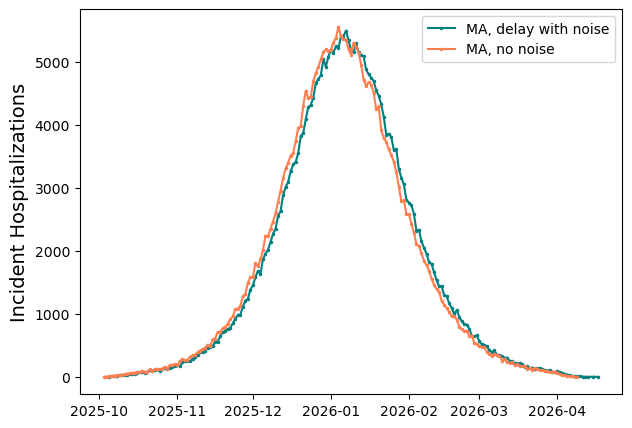

In [306]:
plt.figure(figsize=(7,5))

plt.plot(MAdelaynoise.report_date, MAdelaynoise['count'],'.-' ,color='teal', linewidth=1.5, label='MA, delay with noise',
        markersize=3)
plt.plot(MAnonoise.report_date, MAnonoise['count'],'.-' ,color='coral', linewidth=1.5, label ='MA, no noise',
        markersize=3)

plt.ylabel('Incident Hospitalizations', fontsize=14)

plt.legend()

#plt.savefig('./inc_hosp_plot_MA.png')

plt.show()

# Evaluation

In [422]:
pred = pd.read_csv('https://raw.githubusercontent.com/epistorm/rt-evaluation/refs/heads/main/data/forecasts/test_forecast_MA_agg.csv')

In [423]:
pred['target_end_date'] = pd.to_datetime(pred['target_end_date'])

In [360]:
def get_prediction_timeseries_plot(df, obsdf):

    # make plot of time series envelope at a given location

    fontsize=14
    color = '#17B1BF'

    intervals = [(0.01,0.99),(0.05,0.95),(0.25,0.75)]
    map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

    predictions = df.copy()
   
    observations = obsdf
    observations = Observations(observations)


    predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
  
    pred = predictions.copy()   

    if len(pred) == 0:
        raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

    predictions = [Predictions(pred, t_col='target_end_date', quantile_col='quantile')][0]

    # make plot
    width = 7
    height = 5
    fig, axes = plt.subplots( figsize=(width, height), sharey=True)

    t = np.unique(predictions.get_t())
    
    # plot prediction intervals
    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)
        
        pred_low = predictions.get_quantile(q_low)
        pred_upp = predictions.get_quantile(q_upp)
        axes.fill_between(t,pred_upp,pred_low, color=color, alpha=alpha,
                               label=fr"PI {int(round(interval_range*100))} %")

    #point estimate
    pred_point = predictions.get_point()
    if len(pred_point) > 0:
        axes.plot(t,pred_point,'-o',color=color, label='Forecast')


    #plot surveillance
    axes.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', markersize=3, 
            label='Observation Data')

    #set x axis


    #set y axis 
    plt.ylabel(f"Weekly incident hospitalizations", fontsize=14)

    axes.set_xlim([pd.to_datetime('2025-11-15'), pd.to_datetime('2026-01-15')])
    #axes.set_ylim([0, 250])

    set_date_axis_fmt_wk(axes)
        
    plt.title('State: MA, Method: EpiEstim')
   # axes.plot(t,pred_point,'-o',color=color, label='Forecast')
    plt.legend()

   # plt.show()

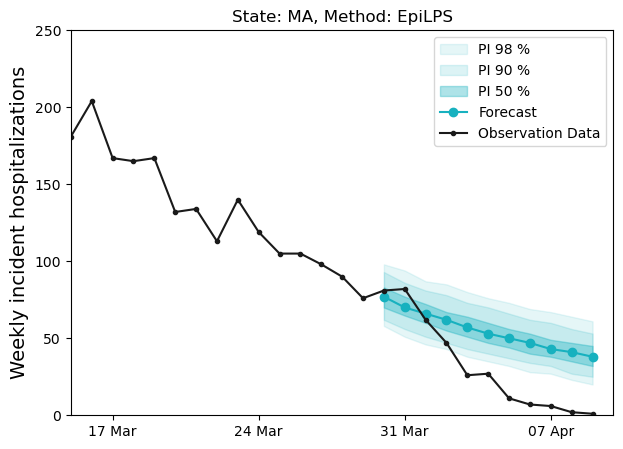

In [341]:
obs = MAnonoise.rename(columns={'report_date':'date', 'count':'value'})
pred = pred[pred.target_end_date<=obs.date.max()]
get_prediction_timeseries_plot(df=pred, obsdf=obs)

plt.savefig('./figs/forecast_MA_zoom.png')

In [424]:
pred['target_end_date'] = pd.to_datetime(pred['target_end_date'])
pred['location'] = 'MA'
obs['date'] = pd.to_datetime(obs['date'])
obs['location'] = 'MA'

preds = pred[pred.target_end_date<=obs.date.max()].sort_values(by='target_end_date')
obsfilt = obs.sort_values(by='date')
test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = None, end_week = None)
timestamp_score = test2.organize_timestamped_scores(want_scores=['wis'])

In [251]:
timestamp_score

,Model,location,target_end_date,wis
0,1 week ahead forecast,MA,2026-03-30,2.671802
1,1 week ahead forecast,MA,2026-03-31,6.348541
2,1 week ahead forecast,MA,2026-04-01,2.534565
3,1 week ahead forecast,MA,2026-04-02,8.546087
4,1 week ahead forecast,MA,2026-04-03,24.997391
5,1 week ahead forecast,MA,2026-04-04,20.295887
6,1 week ahead forecast,MA,2026-04-05,33.063913
7,1 week ahead forecast,MA,2026-04-06,33.555217
8,1 week ahead forecast,MA,2026-04-07,31.862826
9,1 week ahead forecast,MA,2026-04-08,32.655009


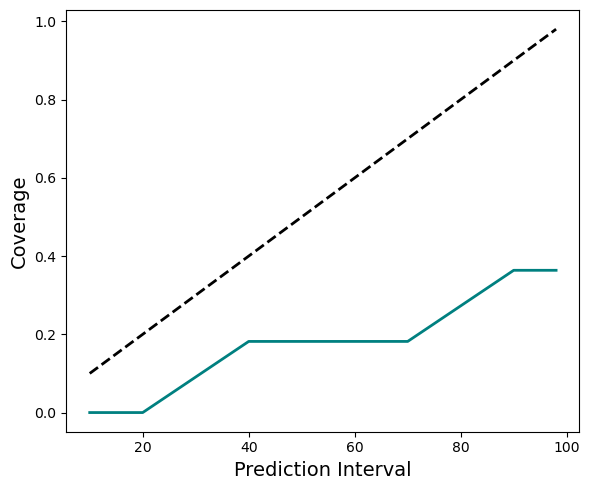

In [425]:
#plot coverage
obsfilt = obsfilt[(obsfilt.date>=pred.target_end_date.min()) ]

test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = None, end_week = None)

fig, ax = plt.subplots(1,1,figsize = (6,5),tight_layout = False)

#coverage prediction intervals
covers = [10,20,30,40,50,60,70,80,90,95,98]
covsy = [cv/100 for cv in covers]

# get all coverage scores averaged over time window
df = test2.organize_average_scores(want_scores=['10_cov', '20_cov', '30_cov', '40_cov', '50_cov',\
                                              '60_cov', '70_cov', '80_cov', '90_cov', '95_cov', '98_cov'])


#dfgroup = df.groupby(['Model'], as_index=False).mean()

N = len(df.location.unique())

cmap = plt.get_cmap('Set2', N)
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

i=0
for location in df.location.unique():
    dfplot = df[df.location == location]

    covs = list(dfplot[['10_cov', '20_cov', '30_cov', '40_cov', '50_cov','60_cov', '70_cov', '80_cov', 
                 '90_cov', '95_cov', '98_cov']].values[0])

# plot
    plt.plot(covers, covs, '-',color='teal', label =location, linewidth=2)

    i += 1

plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2) 

plt.xlabel('Prediction Interval', fontsize=14)
plt.ylabel('Coverage', fontsize=14)

#plt.legend(fontsize=12)


plt.savefig('./figs/coverage.png')
plt.show()


In [269]:
obsmerge = obsfilt.rename(columns={'date':'target_end_date'}).drop(columns=['STATEFP'])
df = timestamp_score.merge(obsmerge, on=['target_end_date', 'location'])
df['wis_norm'] = df['wis'] / df['value']

In [270]:
df

,Model,location,target_end_date,wis,state,value,wis_norm
0,1 week ahead forecast,MA,2026-03-30,2.671802,Massachusetts,81,0.032985
1,1 week ahead forecast,MA,2026-03-31,6.348541,Massachusetts,82,0.077421
2,1 week ahead forecast,MA,2026-04-01,2.534565,Massachusetts,62,0.040880
3,1 week ahead forecast,MA,2026-04-02,8.546087,Massachusetts,47,0.181832
4,1 week ahead forecast,MA,2026-04-03,24.997391,Massachusetts,26,0.961438
5,1 week ahead forecast,MA,2026-04-04,20.295887,Massachusetts,27,0.751700
6,1 week ahead forecast,MA,2026-04-05,33.063913,Massachusetts,11,3.005810
7,1 week ahead forecast,MA,2026-04-06,33.555217,Massachusetts,7,4.793602
8,1 week ahead forecast,MA,2026-04-07,31.862826,Massachusetts,6,5.310471
9,1 week ahead forecast,MA,2026-04-08,32.655009,Massachusetts,2,16.327504


<Axes: xlabel='wis_norm', ylabel='location'>

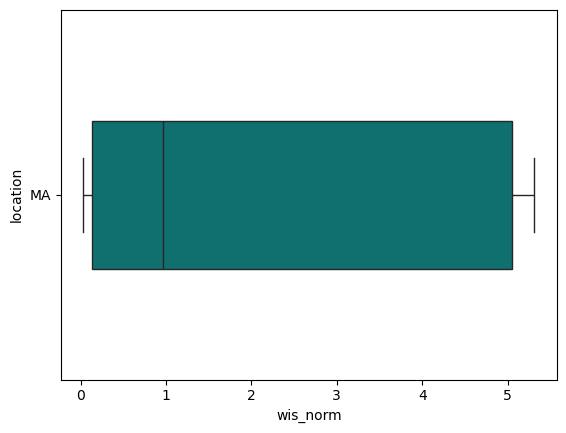

In [273]:
sns.boxplot(x='wis_norm', y='location', data=df,width=.4, color='teal',showfliers=False)

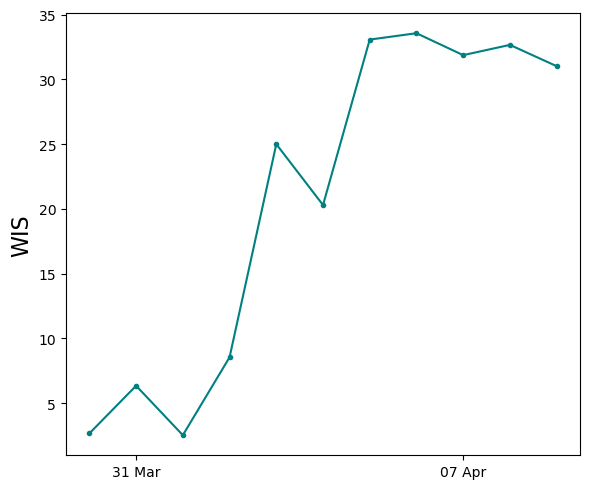

In [286]:
fig, ax = plt.subplots(1,1,figsize = (6,5),tight_layout = False)
plt.plot(df.target_end_date, df.wis,'.-', color='teal')

plt.ylabel('WIS', fontsize=16)
set_date_axis_fmt_wk(ax)

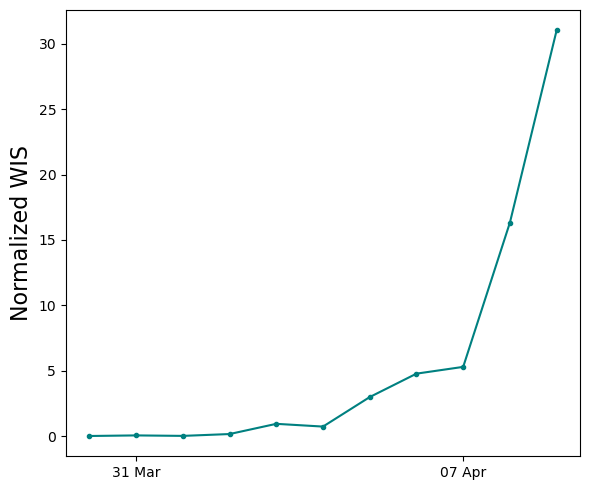

In [287]:
fig, ax = plt.subplots(1,1,figsize = (6,5),tight_layout = False)

plt.plot(df.target_end_date, df.wis_norm, '.-', color='teal')

plt.ylabel('Normalized WIS', fontsize=16)
set_date_axis_fmt_wk(ax)

In [285]:
def set_date_axis_fmt_wk(ax):
    # Set the locator to every week
    locator = mdates.WeekdayLocator()  # every week

    # Specify the format to show the day of the week and the date
    fmt = mdates.DateFormatter('%d %b')

    # Get the X axis from the axis object
    X = ax.xaxis

    # Set the major locator to weekly
    X.set_major_locator(locator)

    # Set the major formatter to the defined format
    X.set_major_formatter(fmt)

    # Auto-format the date labels for better readability
    #ax.figure.autofmt_xdate()

In [343]:
epiestim_nonoise =pd.read_csv('https://raw.githubusercontent.com/epistorm/rt-evaluation/refs/heads/main/data/forecasts/forecast_epiestim_nonoise.csv')

In [344]:
epiestim_nonoise['target_end_date'] = pd.to_datetime(epiestim_nonoise['target_end_date'])

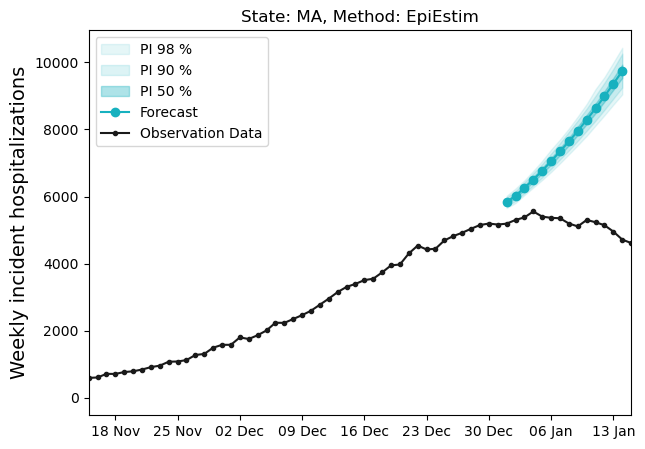

In [362]:
obs = MAnonoise.rename(columns={'report_date':'date', 'count':'value'})
epiestim_nonoise = epiestim_nonoise[epiestim_nonoise.target_end_date<=obs.date.max()]
get_prediction_timeseries_plot(df=epiestim_nonoise, obsdf=obs)

plt.savefig('./figs/forecast_MAepiestim_zoom.png')

In [364]:
epiestim_nonoise['target_end_date'] = pd.to_datetime(epiestim_nonoise['target_end_date'])
epiestim_nonoise['location'] = 'MA'
obs['date'] = pd.to_datetime(obs['date'])
obs['location'] = 'MA'

preds = epiestim_nonoise[epiestim_nonoise.target_end_date<=obs.date.max()].sort_values(by='target_end_date')
obsfilt = obs.sort_values(by='date')
test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = None, end_week = None)
timestamp_score = test2.organize_timestamped_scores(want_scores=['wis'])

obsmerge = obsfilt.rename(columns={'date':'target_end_date'}).drop(columns=['STATEFP'])
df = timestamp_score.merge(obsmerge, on=['target_end_date', 'location'])
df['wis_norm'] = df['wis'] / df['value']

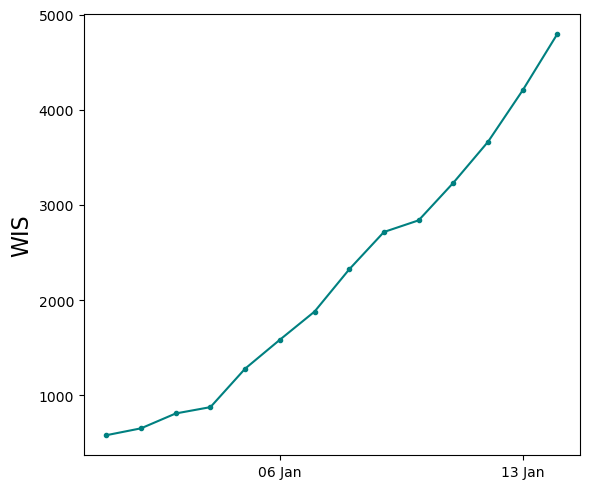

In [365]:
fig, ax = plt.subplots(1,1,figsize = (6,5),tight_layout = False)
plt.plot(df.target_end_date, df.wis,'.-', color='teal')

plt.ylabel('WIS', fontsize=16)
set_date_axis_fmt_wk(ax)

In [381]:
epifilter_nonoise = pd.read_csv('https://raw.githubusercontent.com/epistorm/rt-evaluation/refs/heads/main/data/forecasts/forecast_epifilter_nonoise.csv')

In [382]:
epifilter_nonoise['target_end_date'] = pd.to_datetime(epifilter_nonoise['target_end_date'])

In [393]:
epinow_nonoise = pd.read_csv('https://raw.githubusercontent.com/epistorm/rt-evaluation/refs/heads/main/data/forecasts/forecast_epinow_nonoise.csv')

In [394]:
epinow_nonoise['target_end_date'] = pd.to_datetime(epinow_nonoise['target_end_date'])

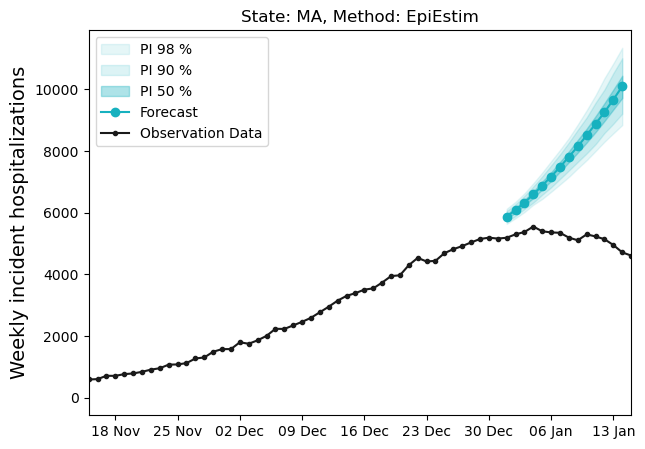

In [383]:
obs = MAnonoise.rename(columns={'report_date':'date', 'count':'value'})
epifilter_nonoise = epifilter_nonoise[epifilter_nonoise.target_end_date<=obs.date.max()]
get_prediction_timeseries_plot(df=epifilter_nonoise, obsdf=obs)

#plt.savefig('./figs/forecast_MAepiestim_zoom.png')

In [384]:
epifilter_nonoise

,quantile,target_end_date,value
0,0.01,2026-01-01,5641.98
1,0.01,2026-01-02,5823.98
2,0.01,2026-01-03,6021.99
3,0.01,2026-01-04,6260.93
4,0.01,2026-01-05,6448.74
...,...,...,...
317,0.99,2026-01-10,9325.02
318,0.99,2026-01-11,9814.28
319,0.99,2026-01-12,10367.17
320,0.99,2026-01-13,10845.37


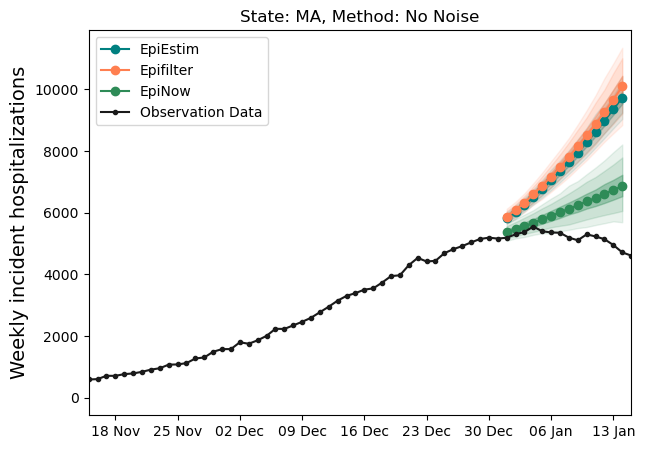

In [413]:
fontsize=14
color = '#17B1BF'

intervals = [(0.01,0.99),(0.05,0.95),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

observations = obs.copy()
observations = Observations(observations)

# make plot
width = 7
height = 5
fig, axes = plt.subplots( figsize=(width, height), sharey=True)


colors = ['teal', 'coral', 'seagreen']
labels = ['EpiEstim', 'Epifilter', 'EpiNow']
i=0

for predictions in [epiestim_nonoise, epifilter_nonoise, epinow_nonoise]:

    predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
    
    pred = predictions.copy()   

    if len(pred) == 0:
        raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

    predictions = [Predictions(pred, t_col='target_end_date', quantile_col='quantile')][0]

    t = np.unique(predictions.get_t())
   
    # plot intervals
    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)

        pred_low = predictions.get_quantile(q_low)
        pred_upp = predictions.get_quantile(q_upp)
        axes.fill_between(t,pred_upp,pred_low, color=colors[i], alpha=alpha,
                               )

    #point estimate
    pred_point = predictions.get_point()
    if len(pred_point) > 0:
        axes.plot(t,pred_point,'-o',color=colors[i], label=labels[i])
        
    i+=1


#plot surveillance
axes.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', markersize=3, 
        label='Observation Data')

#set y axis 
plt.ylabel(f"Weekly incident hospitalizations", fontsize=14)

axes.set_xlim([pd.to_datetime('2025-11-15'), pd.to_datetime('2026-01-15')])
#axes.set_ylim([0, 250])

set_date_axis_fmt_wk(axes)

plt.title('State: MA, Method: No Noise')
# axes.plot(t,pred_point,'-o',color=color, label='Forecast')
plt.legend()

# plt.show()

plt.savefig('./figs/forecasts_MA_nonoise.png')

In [441]:
# calculate scores for all forecasts

# Epiestim
epiestim_nonoise['target_end_date'] = pd.to_datetime(epiestim_nonoise['target_end_date'])
epiestim_nonoise['location'] = 'MA'
obs['date'] = pd.to_datetime(obs['date'])
obs['location'] = 'MA'

preds = epiestim_nonoise[epiestim_nonoise.target_end_date<=obs.date.max()].sort_values(by='target_end_date')
obsfilt = obs.sort_values(by='date')
test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = None, end_week = None)
epiestim_score = test2.organize_timestamped_scores(want_scores=['wis'])

obsmerge = obsfilt.rename(columns={'date':'target_end_date'}).drop(columns=['STATEFP'])
epiestimdf = epiestim_score.merge(obsmerge, on=['target_end_date', 'location'])
epiestimdf['wis_norm'] = epiestimdf['wis'] / epiestimdf['value']
epiestimdf['Method'] = 'EpiEstim'

#### Epifilter
epifilter_nonoise['target_end_date'] = pd.to_datetime(epifilter_nonoise['target_end_date'])
epifilter_nonoise['location'] = 'MA'
obs['date'] = pd.to_datetime(obs['date'])
obs['location'] = 'MA'

preds = epifilter_nonoise[epifilter_nonoise.target_end_date<=obs.date.max()].sort_values(by='target_end_date')
obsfilt = obs.sort_values(by='date')
test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = None, end_week = None)
epifilter_score = test2.organize_timestamped_scores(want_scores=['wis'])

obsmerge = obsfilt.rename(columns={'date':'target_end_date'}).drop(columns=['STATEFP'])
epifilterdf = epifilter_score.merge(obsmerge, on=['target_end_date', 'location'])
epifilterdf['wis_norm'] = epifilterdf['wis'] / epifilterdf['value']
epifilterdf['Method'] = 'EpiFilter'

### Epinow
epinow_nonoise['target_end_date'] = pd.to_datetime(epinow_nonoise['target_end_date'])
epinow_nonoise['location'] = 'MA'
obs['date'] = pd.to_datetime(obs['date'])
obs['location'] = 'MA'

preds = epinow_nonoise[epinow_nonoise.target_end_date<=obs.date.max()].sort_values(by='target_end_date')
obsfilt = obs.sort_values(by='date')
test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = None, end_week = None)
epinow_score = test2.organize_timestamped_scores(want_scores=['wis'])

obsmerge = obsfilt.rename(columns={'date':'target_end_date'}).drop(columns=['STATEFP'])
epinowdf = epinow_score.merge(obsmerge, on=['target_end_date', 'location'])
epinowdf['wis_norm'] = epinowdf['wis'] / epinowdf['value']
epinowdf['Method'] = 'EpiNow'




In [442]:
nonoise_scores = pd.concat([epiestimdf, epifilterdf, epinowdf])

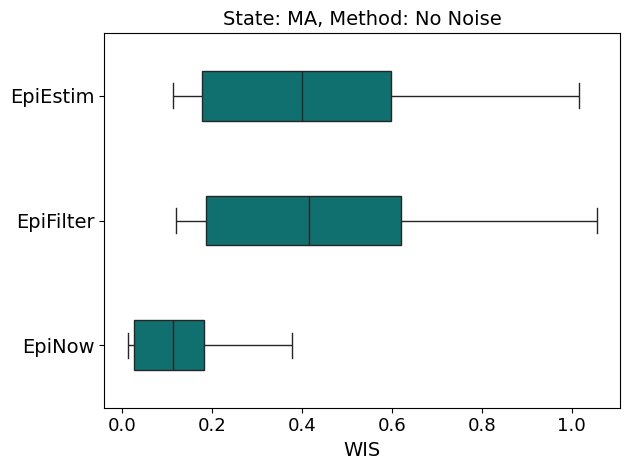

In [482]:
sns.boxplot(x='wis_norm', y='Method',data=nonoise_scores, color='teal', width=.4)
plt.xlabel('WIS', fontsize=14)
plt.ylabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=13)
plt.title('State: MA, Method: No Noise', fontsize=14)
plt.tight_layout()
plt.savefig('./figs/normalized_wis_nonoise_MA.png')

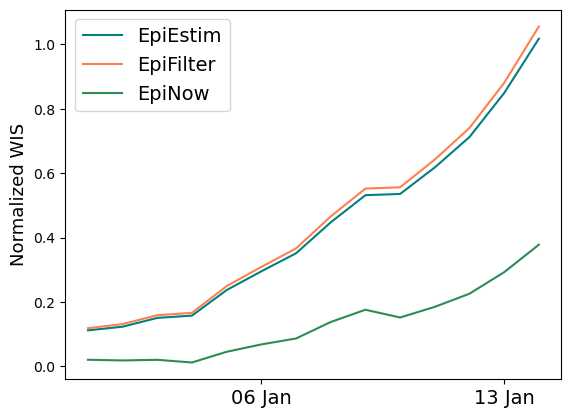

In [478]:
fig, ax= plt.subplots()
i=0
for method in nonoise_scores.Method.unique():
    df = nonoise_scores[nonoise_scores.Method==method]
    
    plt.plot(df.target_end_date, df.wis_norm,color=colors[i], label=method)
    
    i+=1
    
set_date_axis_fmt_wk(ax)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Normalized WIS', fontsize=13)

plt.savefig('./figs/WIS_overtime.png')

In [429]:
##  get forecasts with noise

epiestim_noise = pd.read_csv('https://raw.githubusercontent.com/epistorm/rt-evaluation/refs/heads/main/data/forecasts/forecast_epiestim_noise-reporting.csv')
epifilter_noise = pd.read_csv('https://raw.githubusercontent.com/epistorm/rt-evaluation/refs/heads/main/data/forecasts/forecast_epifilter_noise-reporting.csv')
epilps_noise = pd.read_csv('https://raw.githubusercontent.com/epistorm/rt-evaluation/refs/heads/main/data/forecasts/forecast_epilps_noise-reporting.csv')
epinow_noise = pd.read_csv('https://raw.githubusercontent.com/epistorm/rt-evaluation/refs/heads/main/data/forecasts/forecast_epinow_noise-reporting.csv')


epiestim_noise['target_end_date'] = pd.to_datetime(epiestim_noise['target_end_date'])
epifilter_noise['target_end_date'] = pd.to_datetime(epifilter_noise['target_end_date'])
epilps_noise['target_end_date'] = pd.to_datetime(epilps_noise['target_end_date'])
epinow_noise['target_end_date'] = pd.to_datetime(epinow_noise['target_end_date'])

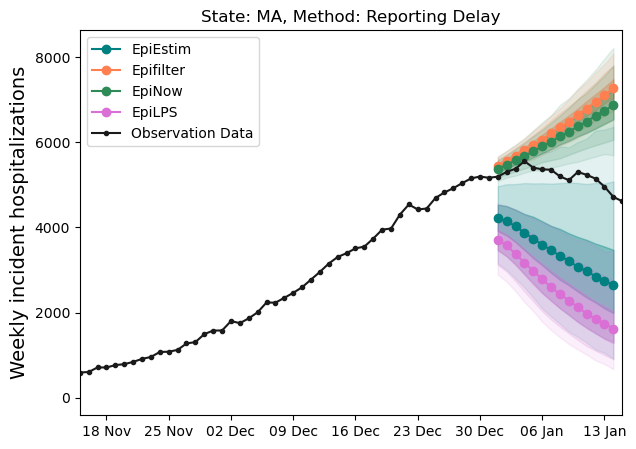

In [430]:
#plot forecasts

fontsize=14
color = '#17B1BF'

intervals = [(0.01,0.99),(0.05,0.95),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

#predictions = df.copy()
# locations = self.get_locations()
observations = obs.copy()
observations = Observations(observations)

# make plot
width = 7
height = 5
fig, axes = plt.subplots( figsize=(width, height), sharey=True)


colors = ['teal', 'coral', 'seagreen', 'orchid']
labels = ['EpiEstim', 'Epifilter', 'EpiNow', 'EpiLPS']
i=0

for predictions in [epiestim_noise, epifilter_noise, epinow_noise, epilps_noise]:

    predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
   
    pred = predictions.copy()   

    if len(pred) == 0:
        raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

    predictions = [Predictions(pred, t_col='target_end_date', quantile_col='quantile')][0]

    t = np.unique(predictions.get_t())
    
    #plot intervals
    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)

        pred_low = predictions.get_quantile(q_low)
        pred_upp = predictions.get_quantile(q_upp)
        axes.fill_between(t,pred_upp,pred_low, color=colors[i], alpha=alpha,
                               )
    #point estimate
    pred_point = predictions.get_point()
    if len(pred_point) > 0:
        axes.plot(t,pred_point,'-o',color=colors[i], label=labels[i])
        
    i+=1

#plot surveillance
axes.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', markersize=3, 
        label='Observation Data')

#set y axis 
plt.ylabel(f"Weekly incident hospitalizations", fontsize=14)

axes.set_xlim([pd.to_datetime('2025-11-15'), pd.to_datetime('2026-01-15')])
#axes.set_ylim([0, 250])

set_date_axis_fmt_wk(axes)

plt.title('State: MA, Method: Reporting Delay')
# axes.plot(t,pred_point,'-o',color=color, label='Forecast')
plt.legend()

# plt.show()

plt.savefig('./figs/forecasts_MA_noise.png')

In [443]:
# calculate scores

# Epiestim
epiestim_noise['target_end_date'] = pd.to_datetime(epiestim_noise['target_end_date'])
epiestim_noise['location'] = 'MA'
obs['date'] = pd.to_datetime(obs['date'])
obs['location'] = 'MA'

preds = epiestim_noise[epiestim_noise.target_end_date<=obs.date.max()].sort_values(by='target_end_date')
obsfilt = obs.sort_values(by='date')
test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = None, end_week = None)
epiestim_score = test2.organize_timestamped_scores(want_scores=['wis'])

obsmerge = obsfilt.rename(columns={'date':'target_end_date'}).drop(columns=['STATEFP'])
epiestimdf = epiestim_score.merge(obsmerge, on=['target_end_date', 'location'])
epiestimdf['wis_norm'] = epiestimdf['wis'] / epiestimdf['value']
epiestimdf['Method'] = 'EpiEstim'

#### Epifilter
epifilter_noise['target_end_date'] = pd.to_datetime(epifilter_noise['target_end_date'])
epifilter_noise['location'] = 'MA'
obs['date'] = pd.to_datetime(obs['date'])
obs['location'] = 'MA'

preds = epifilter_nonoise[epifilter_noise.target_end_date<=obs.date.max()].sort_values(by='target_end_date')
obsfilt = obs.sort_values(by='date')
test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = None, end_week = None)
epifilter_score = test2.organize_timestamped_scores(want_scores=['wis'])

obsmerge = obsfilt.rename(columns={'date':'target_end_date'}).drop(columns=['STATEFP'])
epifilterdf = epifilter_score.merge(obsmerge, on=['target_end_date', 'location'])
epifilterdf['wis_norm'] = epifilterdf['wis'] / epifilterdf['value']
epifilterdf['Method'] = 'EpiFilter'

### Epinow
epinow_noise['target_end_date'] = pd.to_datetime(epinow_nonoise['target_end_date'])
epinow_noise['location'] = 'MA'
obs['date'] = pd.to_datetime(obs['date'])
obs['location'] = 'MA'

preds = epinow_noise[epinow_noise.target_end_date<=obs.date.max()].sort_values(by='target_end_date')
obsfilt = obs.sort_values(by='date')
test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = None, end_week = None)
epinow_score = test2.organize_timestamped_scores(want_scores=['wis'])

obsmerge = obsfilt.rename(columns={'date':'target_end_date'}).drop(columns=['STATEFP'])
epinowdf = epinow_score.merge(obsmerge, on=['target_end_date', 'location'])
epinowdf['wis_norm'] = epinowdf['wis'] / epinowdf['value']
epinowdf['Method'] = 'EpiNow'


### EpiLPS
epilps_noise['target_end_date'] = pd.to_datetime(epilps_noise['target_end_date'])
epilps_noise['location'] = 'MA'
obs['date'] = pd.to_datetime(obs['date'])
obs['location'] = 'MA'

preds = epilps_noise[epilps_noise.target_end_date<=obs.date.max()].sort_values(by='target_end_date')
obsfilt = obs.sort_values(by='date')
test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = None, end_week = None)
epilps_score = test2.organize_timestamped_scores(want_scores=['wis'])

obsmerge = obsfilt.rename(columns={'date':'target_end_date'}).drop(columns=['STATEFP'])
epilpsdf = epilps_score.merge(obsmerge, on=['target_end_date', 'location'])
epilpsdf['wis_norm'] = epilpsdf['wis'] / epilpsdf['value']
epilpsdf['Method'] = 'EpiLPS'




In [444]:
noise_scores = pd.concat([epiestimdf, epifilterdf, epinowdf, epilpsdf])

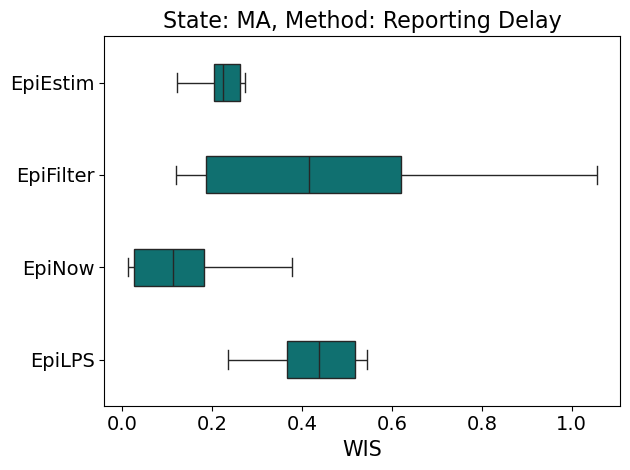

In [473]:
my_order = noise_scores.groupby(by=["Model"])["wis_norm"].median().sort_values(ascending=False).index
    
sns.boxplot(x='wis_norm', y='Method',data=noise_scores, color='teal', width=.4)
plt.xlabel('WIS', fontsize=15)
plt.ylabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('State: MA, Method: Reporting Delay', fontsize=16)
plt.tight_layout()
plt.savefig('./figs/normalized_wis_noise_MA.png')

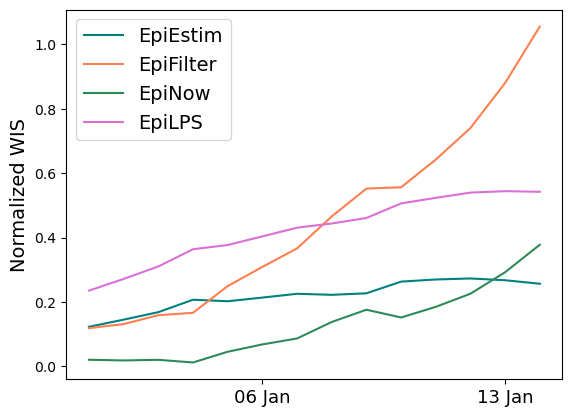

In [476]:
fig, ax= plt.subplots()
i=0
for method in noise_scores.Method.unique():
    df = noise_scores[noise_scores.Method==method]
    
    plt.plot(df.target_end_date, df.wis_norm,color=colors[i], label=method)
    
    i+=1
    
set_date_axis_fmt_wk(ax)
plt.legend(fontsize=14)
plt.xticks(fontsize=13)

plt.ylabel('Normalized WIS', fontsize=14)

plt.savefig('./figs/WIS_overtime_noise.png')

In [448]:
nonoise_scores['Noise'] = 'No Noise'
noise_scores['Noise'] = 'Reporting Delay'

all_scores = pd.concat([nonoise_scores, noise_scores])

In [449]:
all_scores

,Model,location,target_end_date,wis,state,value,wis_norm,Method,Noise
0,1 week ahead forecast,MA,2026-01-01,580.098396,Massachusetts,5191,0.111751,EpiEstim,No Noise
1,1 week ahead forecast,MA,2026-01-02,652.416383,Massachusetts,5302,0.123051,EpiEstim,No Noise
2,1 week ahead forecast,MA,2026-01-03,808.575178,Massachusetts,5377,0.150377,EpiEstim,No Noise
3,1 week ahead forecast,MA,2026-01-04,875.113213,Massachusetts,5554,0.157564,EpiEstim,No Noise
4,1 week ahead forecast,MA,2026-01-05,1279.228363,Massachusetts,5401,0.236850,EpiEstim,No Noise
...,...,...,...,...,...,...,...,...,...
9,1 week ahead forecast,MA,2026-01-10,2681.763783,Massachusetts,5301,0.505898,EpiLPS,Reporting Delay
10,1 week ahead forecast,MA,2026-01-11,2737.982287,Massachusetts,5233,0.523215,EpiLPS,Reporting Delay
11,1 week ahead forecast,MA,2026-01-12,2775.006939,Massachusetts,5144,0.539465,EpiLPS,Reporting Delay
12,1 week ahead forecast,MA,2026-01-13,2695.152446,Massachusetts,4955,0.543926,EpiLPS,Reporting Delay


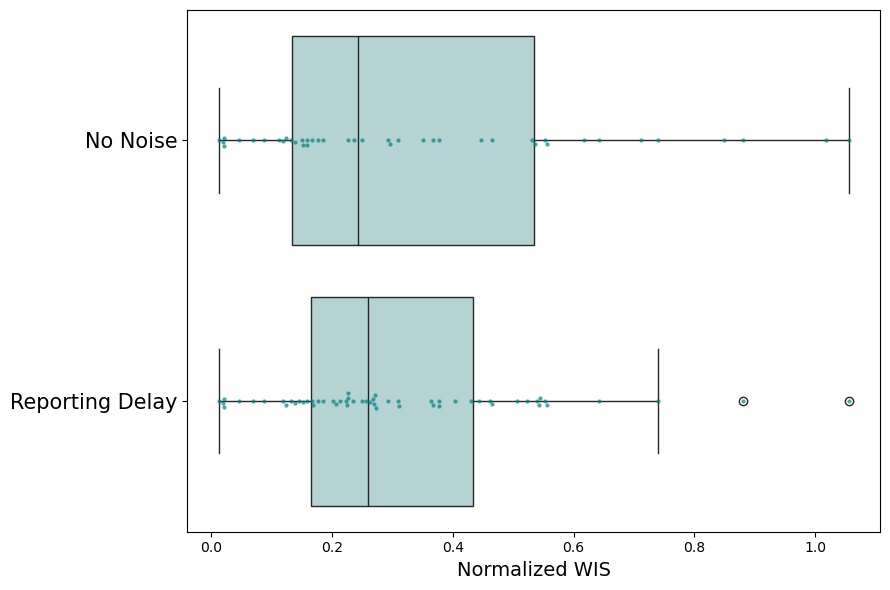

In [468]:
# compare forecasts with and without noise

fig, ax = plt.subplots(figsize=(9,6))

sns.boxplot(x='wis_norm', y='Noise', data=all_scores, color='teal')

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
sns.swarmplot(x='wis_norm', y='Noise', data=all_scores,color = "teal",alpha = .7,size=3, orient="h")    
plt.ylabel('')
plt.xlabel('Normalized WIS', fontsize=14)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('./figs/compare_noise.png')

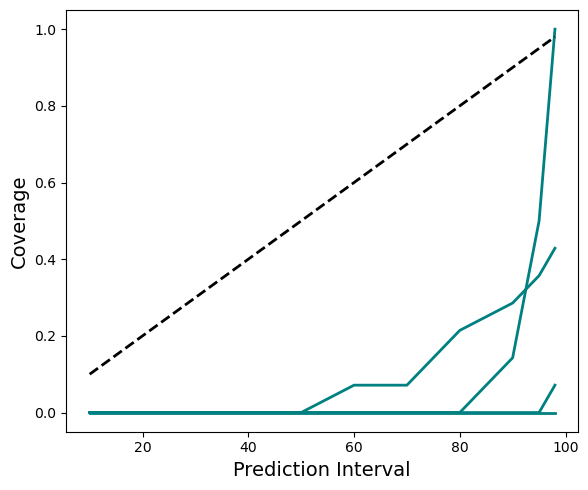

In [489]:
#plot coverage

fig, ax = plt.subplots(1,1,figsize = (6,5),tight_layout = False)
for pred in [epiestim_noise, epifilter_noise, epinow_noise, epilps_noise]:

    obsfilt = obs[(obs.date>=pred.target_end_date.min()) & (obs.date<=pred.target_end_date.max()) ]
    preds = pred[pred.target_end_date<=obs.date.max()].sort_values(by='target_end_date')

    test2 = Scoring(df=preds, obsdf=obsfilt,scoredf = preds, 
                   target='hosp', incidence = True, max_date = False, 
                            start_week = None, end_week = None)

    

    #coverage prediction intervals
    covers = [10,20,30,40,50,60,70,80,90,95,98]
    covsy = [cv/100 for cv in covers]

    # get all coverage scores averaged over time window
    df = test2.organize_average_scores(want_scores=['10_cov', '20_cov', '30_cov', '40_cov', '50_cov',\
                                                  '60_cov', '70_cov', '80_cov', '90_cov', '95_cov', '98_cov'])


    #dfgroup = df.groupby(['Model'], as_index=False).mean()

    N = len(df.location.unique())

    cmap = plt.get_cmap('Set2', N)
    custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

    i=0
    for location in df.location.unique():
        dfplot = df[df.location == location]

        covs = list(dfplot[['10_cov', '20_cov', '30_cov', '40_cov', '50_cov','60_cov', '70_cov', '80_cov', 
                     '90_cov', '95_cov', '98_cov']].values[0])

    # plot
        plt.plot(covers, covs, '-',color='teal', label =location, linewidth=2)

        i += 1

plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2) 

plt.xlabel('Prediction Interval', fontsize=14)
plt.ylabel('Coverage', fontsize=14)

#plt.legend(fontsize=12)

plt.show()